# Deep Q Learning (DQN)

## Summary

- Custom Grid Environment (refer to grid_environment folder for more information)
- Class for Deep Q Learning algorithm
- Deep Q Learning implementation on custom grid environment
- Analysis of Deep Q Learning implementation

In [19]:
# Imports

import random
import pickle
import numpy as np
import gymnasium as gym

from collections import deque

import matplotlib.pyplot as plt

from keras.backend import clear_session
from keras.models import Model, load_model
from keras.layers import Input, Dense
from keras.optimizers import RMSprop

import warnings
warnings.filterwarnings('ignore')

## DQN Class

In [10]:
class DQN:
  def __init__(self, environment, observation_space, action_space, max_episode_steps, episodes=120, gamma=0.95, learning_rate=0.001, batch_szie=64, epsilon=1.0, epsilon_decay=0.999, epsilon_min=0.001):
    self.environment = environment
    self.observation_space = observation_space
    self.action_space = action_space
    self.max_episode_steps = max_episode_steps
    self.memory = deque(maxlen=2000)

    self.gamma = gamma
    self.learning_rate = learning_rate # 0.00025
    self.batch_size = batch_szie
    self.epsilon = epsilon
    self.epsilon_decay = epsilon_decay
    self.epsilon_min = epsilon_min
    self.episodes = episodes
    self.train_num = 1000

    self.model = self.build_model()

    self.dqn_reward, self.dqn_reward_avg, self.dqn_epsilon = [], [], []
    self.dqn_reward_test, self.dqn_reward_avg_test = [], []

  def build_model(self):
    # input_shape = (self.observation_space,)
    output_shape = self.action_space
    # input = Input(input_shape)
    input = Input(shape=(self.observation_space,))

    x = Dense(512, input_shape=(self.observation_space,), activation='relu', kernel_initializer='he_uniform')(input)
    x = Dense(256, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(64, activation='relu', kernel_initializer='he_uniform')(x)
    x = Dense(output_shape, activation='relu', kernel_initializer='he_uniform')(x)
    
    model = Model(inputs=input, outputs=x, name='DQN')
    model.compile(loss='mse', optimizer=RMSprop(lr=self.learning_rate, rho=0.95, epsilon=0.01), metrics=['accuracy'])
    model.summary()
    
    return model

  def load(self, model_name):
    self.model = load_model(model_name)

  def save(self, model_name):
    self.model.save(model_name)

  def experience(self, state, action, reward, next_state, done):
    self.memory.append((state, action, reward, next_state, done))
    if len(self.memory) > self.train_num and self.epsilon > self.epsilon_min:
          self.epsilon *= self.epsilon_decay
    
  def replay(self):
    if len(self.memory) < self.train_num:
      return
    batch = random.sample(self.memory, min(len(self.memory), self.batch_size))
    state = np.zeros((self.batch_size, self.observation_space))
    next_state = np.zeros((self.batch_size, self.observation_space))
    action, reward, done = [], [], []
    
    for iter in range(self.batch_size):
      state[iter] = batch[iter][0]
      next_state[iter] = batch[iter][3]
      action.append(batch[iter][1])
      reward.append(batch[iter][2])
      done.append(batch[iter][4])
    
    target = self.model.predict(state, verbose=0)
    target_next = self.model.predict(next_state, verbose=0)

    for iter in range(self.batch_size):
      if done[iter]:
        target[iter][action[iter]] = reward[iter]
      else:
        a_value = np.max(target_next[iter])
        target[iter][action[iter]] = reward[iter] + self.gamma*a_value

    self.model.fit(state, target, batch_size=self.batch_size, verbose=0)

  def action(self, state):
    if np.random.random() <= self.epsilon:
      return random.randrange(self.action_space)
    return np.argmax(self.model.predict(state, verbose=0))
       
  def train(self):
    for episode in range(self.episodes):
      state, info = self.environment.reset()
      state = np.reshape(state, [1, self.observation_space])
      done = False
      score = 0
      steps = 0
      
      while not done:
        action = self.action(state)
        next_state, reward, done, trunc, info = self.environment.step(action)
        next_state = np.reshape(next_state, [1, self.observation_space])

        self.experience(state, action, reward, next_state, done)
        state = next_state        
        score += reward
        steps += 1

        if steps == self.max_episode_steps:
          done = True
          print('Terminating - reached maximum steps')

        if done:                   
          print('Episode: {}, Score: {}, Steps: {}, Epsilon: {}'.format(episode, score, steps, self.epsilon))
          self.dqn_reward.append(score)
          self.dqn_reward_avg.append(sum(self.dqn_reward)/len(self.dqn_reward))
          self.dqn_epsilon.append(self.epsilon)

          clear_session() 
        
        self.replay()
      
  def test(self, model_name):
    self.load(model_name)
    for episode in range(10):
      state, info = self.environment.reset()
      state = np.reshape(state, [1, self.observation_space])
      done = False
      score = 0
      
      while not done:
        action = np.argmax(self.model.predict(state, verbose=0))
        next_state, reward, done, trunc, info = self.environment.step(action)
        state = np.reshape(next_state, [1, self.observation_space])
        score += reward

        if done:
          print('Episode: {}, Score: {}'.format(episode, score))
          self.dqn_reward_test.append(score)
          self.dqn_reward_avg_test.append(sum(self.dqn_reward_test)/len(self.dqn_reward_test))
          break
  
  def get_rewards(self):
    return self.dqn_reward, self.dqn_reward_test

  def plot_reward(self, type):
    if type == 'train':
      reward = self.dqn_reward
      reward_avg = self.dqn_reward_avg
    elif type == 'test':
      reward = self.dqn_reward_test
      reward_avg = self.dqn_reward_avg_test

    plt.figure(figsize=(15, 10))
    plt.plot(reward, 'g', label='Reward')
    plt.plot(reward_avg, 'r', label='Average Reward')
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Reward Value', fontsize=20)
    plt.title('Rewards Per Episode', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.legend()
    plt.show()

  def plot_epsilon(self):
    plt.figure(figsize=(15, 10))
    plt.plot(self.dqn_epsilon)
    plt.xlabel('Episode', fontsize=20)
    plt.ylabel('Epsilon Values', fontsize=20)
    plt.title('Epsilon Decay', fontsize=24)
    plt.xticks(fontsize=16)
    plt.yticks(fontsize=16)
    plt.grid()
    plt.show()

# GridWorld Environment

In [11]:
class GridEnvironment(gym.Env):    
  def __init__(self, environment_type):
    self.environment_type = environment_type
    self.environment_width = 6
    self.environment_height = 6
    
    self.observation_space = gym.spaces.Discrete(self.environment_width * self.environment_height)
    self.action_space = gym.spaces.Discrete(4)
    
    self.max_timesteps = 20
    self.timestep = 0          
    self.agent_pos = np.asarray([0, 0])
    self.gold_pos = np.asarray([4, 5])
    self.gold_quantity = 1
    self.coin_pos = np.asarray([[0,2], [0,4], [1,5], [2,0], [2,2], [2,5], [3,3], [4,0], [4,4], [5,5]])
    self.stack_pos = np.asarray([[1,3], [4,1]]) 
    self.pit_pos = np.asarray([[0,3], [1,1], [2,4], [3,0], [4,2], [5,0], [5,3]])
        
  def reset(self, **kwargs):
    self.timestep = 0          
    self.agent_pos = np.asarray([0, 0])
    self.gold_pos = np.asarray([4, 5])
    self.gold_quantity = 1
    self.coin_pos = np.asarray([[0,2], [0,4], [1,5], [2,0], [2,2], [2,5], [3,3], [4,0], [4,4], [5,5]])
    self.stack_pos = np.asarray([[1,3], [4,1]]) 
    self.pit_pos = np.asarray([[0,3], [1,1], [2,4], [3,0], [4,2], [5,0], [5,3]])
    
    info = {}
    observation = self.one_hot_encoding(self.agent_pos)

    return observation, info
    
  def step(self, action):
    if action == 0:
        self.agent_pos[0] += 1  # This action causes the agent to go right.
    if action == 1:
        self.agent_pos[0] -= 1  # This action causes the agent to go left.
    if action == 2:
        self.agent_pos[1] += 1  # This action causes the agent to go up.
    if action == 3:
        self.agent_pos[1] -= 1  # This action causes the agent to go down.

    # Stochastic Environment
    random_number = random.uniform(0, 1)
    if self.environment_type == 'stochastic' and random_number >= 0.9:
        action = np.random.choice(self.action_space.n)
        
    self.agent_pos = np.clip(self.agent_pos, 0, 5) 
    
    terminated = True if self.timestep >= self.max_timesteps else False
    truncated = True if np.all((self.agent_pos >= 0 ) & (self.agent_pos <= 2)) else False
    
    reward = 0
    agent_list = self.agent_pos.tolist()
    gold_list = self.gold_pos.tolist()
    coin_list = self.coin_pos.tolist()
    stack_list = self.stack_pos.tolist()
    pit_list = self.pit_pos.tolist()         
    
    if agent_list == gold_list:
        reward = 100
        self.gold_pos = np.asarray([])
        terminated = True
    if agent_list in coin_list:
        reward = 1
        coin_list.remove(agent_list)
        self.coin_pos = np.asarray(coin_list)
    if agent_list in stack_list:
        reward = 10
        stack_list.remove(agent_list)
        self.stack_pos = np.asarray(stack_list)
    if agent_list in pit_list:
        reward = -2
        pit_list.remove(agent_list)
        self.pit_pos = np.asarray(pit_list)
    
    observation = self.one_hot_encoding(self.agent_pos)
    self.timestep += 1
    info = {}
    
    return observation, reward, terminated, truncated, info
        
  def one_hot_encoding(self, state):
    input_size = self.observation_space.n
    one_hot = np.zeros(input_size)
    index = state[0] * 6 + state[1]
    one_hot[index] = 1
    return one_hot.reshape(1, -1)

In [12]:
environment = GridEnvironment(environment_type = 'determinstic')
observation_space = environment.observation_space.n
action_space = environment.action_space.n

print('observation_space', observation_space)
print('action_space', action_space)
agent = DQN(environment, observation_space, action_space, 100, episodes=100)

agent.train()

observation_space 36
action_space 4
Model: "DQN"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 36)]              0         
                                                                 
 dense (Dense)               (None, 512)               18944     
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dense_2 (Dense)             (None, 64)                16448     
                                                                 
 dense_3 (Dense)             (None, 4)                 260       
                                                                 
Total params: 166980 (652.27 KB)
Trainable params: 166980 (652.27 KB)
Non-trainable params: 0 (0.00 Byte)
_____________________________________________________

In [16]:
model_name = 'dqn_gridworld.h5'
agent.save(model_name)

In [17]:
agent.test(model_name)

Episode: 0, Score: 113
Episode: 1, Score: 113
Episode: 2, Score: 113
Episode: 3, Score: 113
Episode: 4, Score: 113
Episode: 5, Score: 113
Episode: 6, Score: 113
Episode: 7, Score: 113
Episode: 8, Score: 113
Episode: 9, Score: 113


In [20]:
reward_train, reward_test = agent.get_rewards()

with open('gridworld_dqn_train.pkl', 'wb') as f:
  pickle.dump(reward_train, f)

with open('gridworld_dqn_test.pkl', 'wb') as f:
  pickle.dump(reward_test, f)

### Visualizations

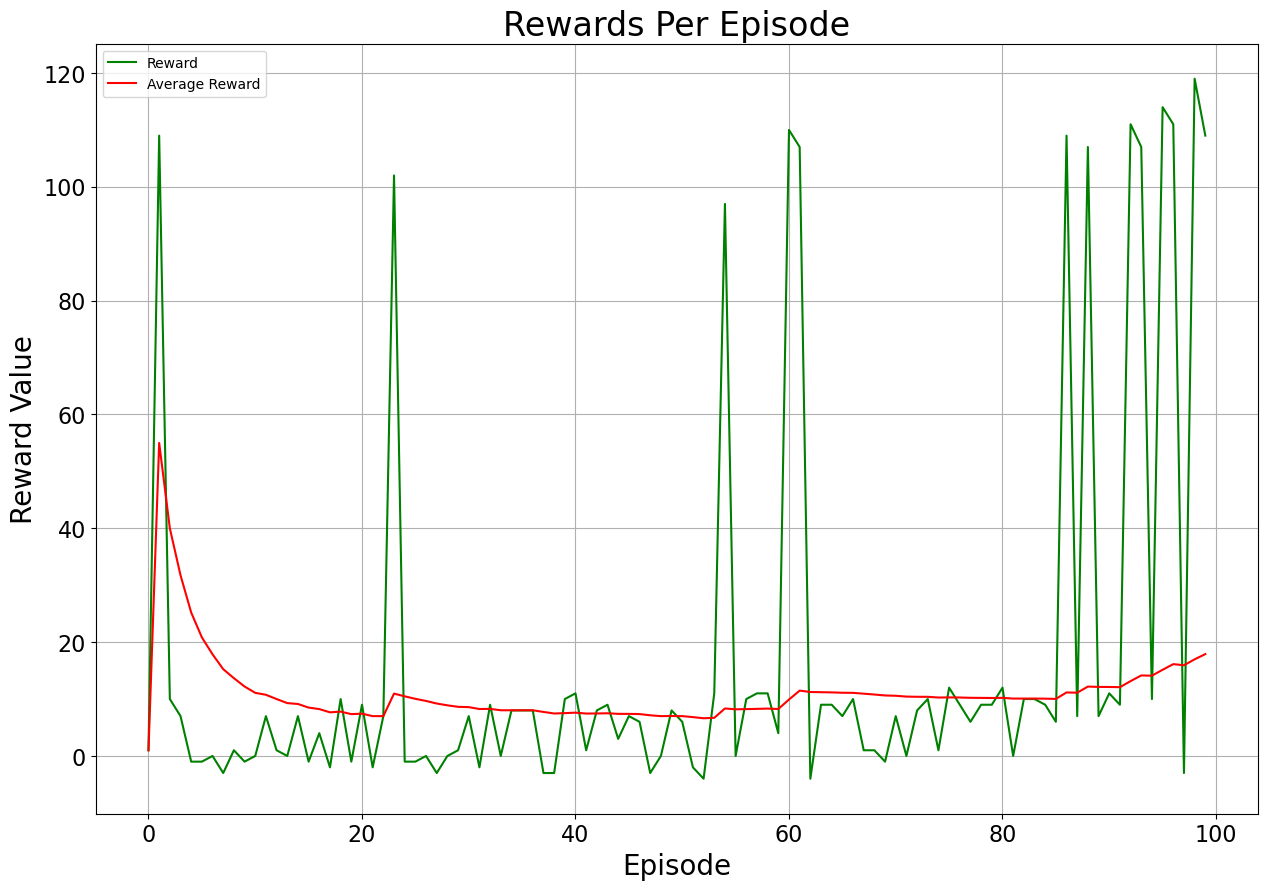

In [21]:
agent.plot_reward('train')

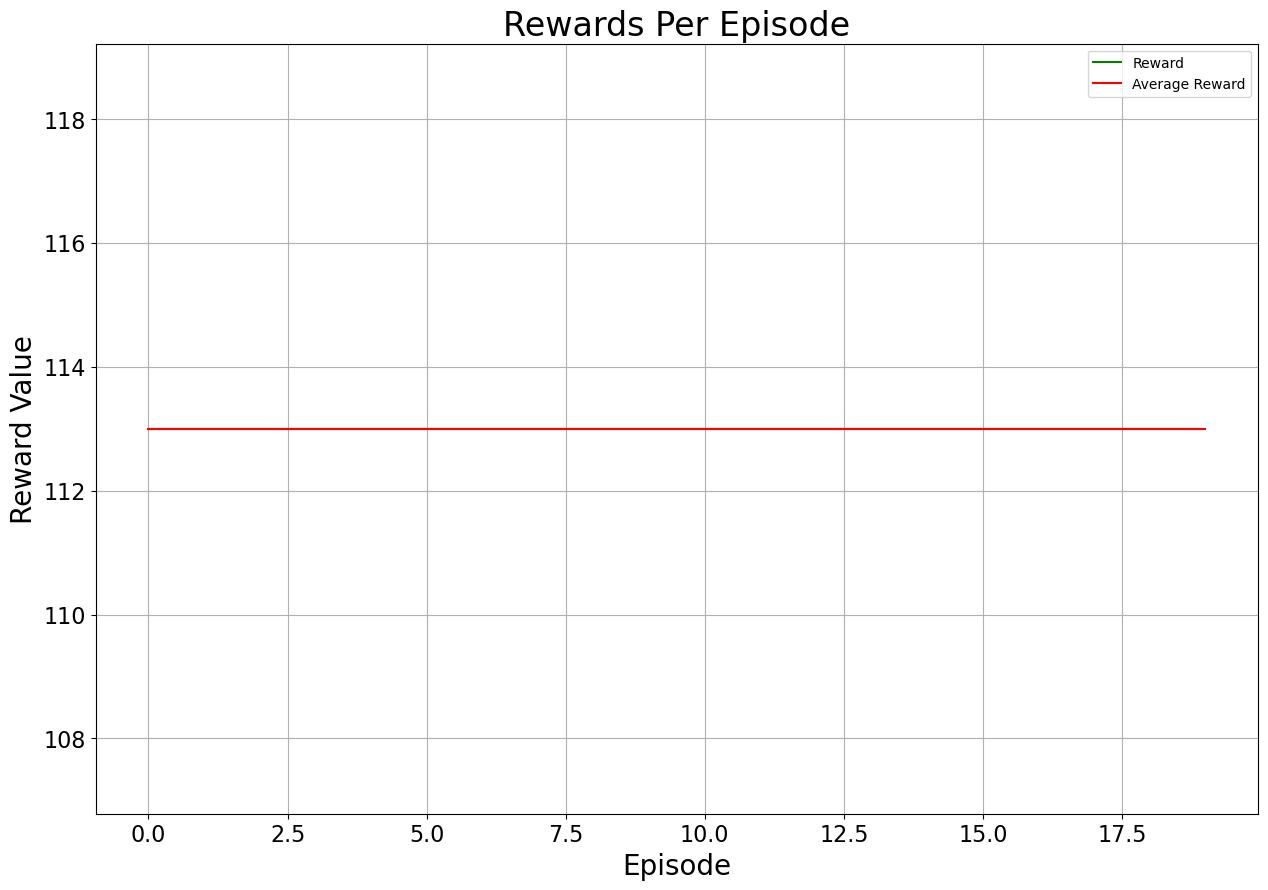

In [22]:
agent.plot_reward('test')

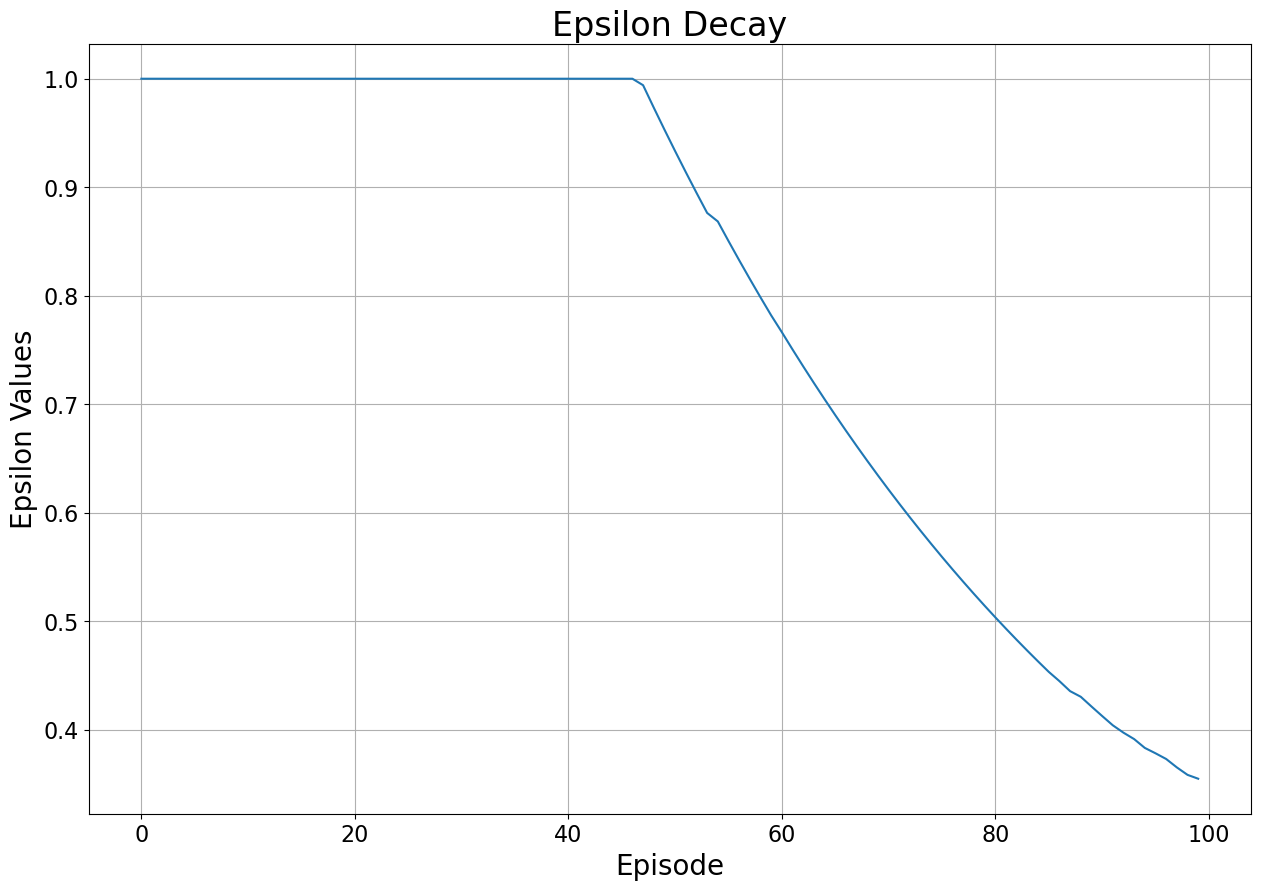

In [23]:
agent.plot_epsilon()